<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/spaceship_titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic

Welcome to the year 2912, where our data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, we need to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

# Import Libraries

In [7]:
!kaggle competitions download -c spaceship-titanic
!chmod 600 /root/.kaggle/kaggle.json

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 63.3MB/s]


In [338]:
!pip install lazypredict --quiet

In [466]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import zipfile
%matplotlib inline

# Load Datasets

In [380]:
zip_path = '/content/spaceship-titanic.zip'
directory_to_extract_to = '/content/spaceship-titanic'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [381]:
train_df = pd.read_csv(directory_to_extract_to+'/train.csv')
test_df = pd.read_csv(directory_to_extract_to+'/test.csv')
sample_submission_df = pd.read_csv(directory_to_extract_to+'/sample_submission.csv')

In [150]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Explore Dataset

In [151]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [152]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Both train and test df have empty values.

In [29]:
for col in train_df.columns:
  print(train_df[col].unique())

['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
['Europa' 'Earth' 'Mars' nan]
[False True nan]
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]
[False True nan]
[   0.  109.   43. ... 1569. 8586.  745.]
[   0.    9. 3576. ... 3208. 6819. 4688.]
[   0.   25.  371. ... 1085.  510. 1872.]
[   0.  549. 6715. ... 2868. 1107. 1643.]
[   0.   44.   49. ... 1164.  971. 3235.]
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']
[False  True]


In [21]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


One thing that jumps out immediately is the heavily skewed data on spends across RoomService, FoodCourt, ShoppingMall, Spa and VRDeck. These need to be normalized and scaled. Age looks fairly distributed.

In [31]:
train_df.corr().Transported

Age            -0.075026
RoomService    -0.244611
FoodCourt       0.046566
ShoppingMall    0.010141
Spa            -0.221131
VRDeck         -0.207075
Transported     1.000000
Name: Transported, dtype: float64

Strong correlators are spending on RoomService, Spa and VRDeck, which suggests an effect of social class.

# Feature Engineer

Let's split Cabin to Deck / Num / Side

In [382]:
cabin_cols =  ['cabin_deck', 'cabin_num', 'cabin_side']
train_df[cabin_cols] = train_df.Cabin.str.split('/',expand=True)
test_df[cabin_cols] = test_df.Cabin.str.split('/',expand=True)

Lets split PassengerId to Passenger_Id, Family_member_no

In [383]:
id_cols =  ['passenger_Id', 'family_member_no']
train_df[id_cols] = train_df.PassengerId.str.split('_',expand=True).astype('int32')
test_df[id_cols] = test_df.PassengerId.str.split('_',expand=True).astype('int32')

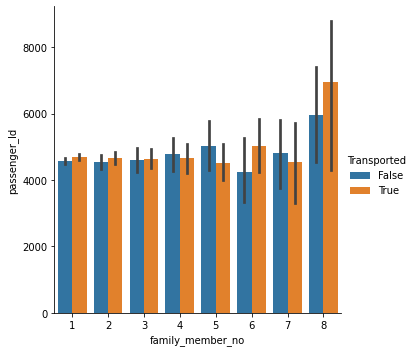

In [67]:
sns.catplot(data=train_df,
            kind="bar",
            x='family_member_no'
            y='passenger_Id',
            hue='Transported',);

Having more family members doesn't seem to affect the chances of being Transported

# Imputing Null Values

In [35]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'cabin_deck', 'cabin_num', 'cabin_side'],
      dtype='object')

Let's assume CryoSleep to be False if missing value and


In [384]:
train_df['CryoSleep'].fillna(False, inplace=True)
test_df['CryoSleep'].fillna(False, inplace=True)

For VIP

In [385]:
train_df['total_spend'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis='columns')
test_df['total_spend'] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0).sum(axis='columns')

❓ maybe use vip column only and discard all spend cols

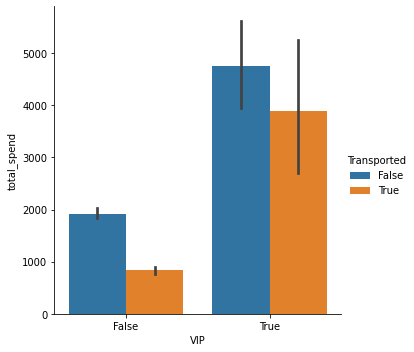

In [139]:
sns.catplot(data=train_df,
            kind="bar",
            x='VIP',
            y='total_spend',
            hue='Transported',);

Lets assume VIP to be anyone whose total spend is above 3000 and rest to be non-vip

In [386]:
train_df.loc[train_df.total_spend>3000,'VIP'] = train_df.loc[train_df.total_spend>3000,'VIP'].fillna(True)
test_df.loc[test_df.total_spend>3000,'VIP'] = test_df.loc[test_df.total_spend>3000,'VIP'].fillna(True)

In [387]:
train_df.VIP.fillna(False,inplace=True)
test_df.VIP.fillna(False,inplace=True)

Let's fill empty values of Spend columns to be 0

In [388]:
train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

Let's fill Age with mean

In [389]:
mean_age = (train_df['Age'].mean() + test_df['Age'].mean()) /2
train_df['Age'].fillna(mean_age, inplace=True)
test_df['Age'].fillna(mean_age, inplace=True)

Destination, HomePlanet, Cabin - deck, side

''

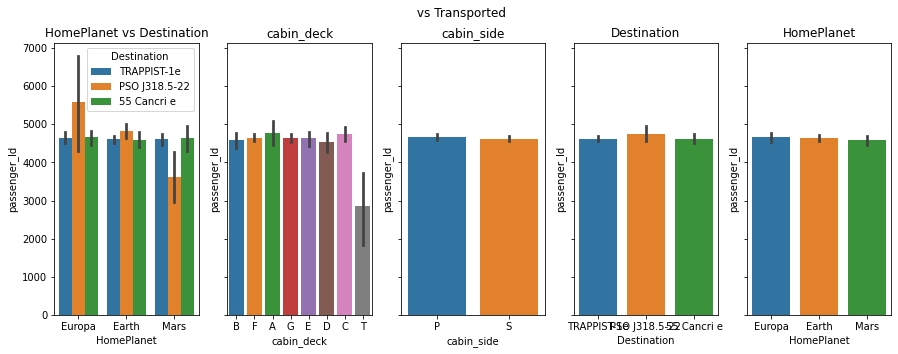

In [203]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
fig.suptitle(' vs Transported')

# 1
sns.barplot(ax=axes[0], x=train_df.HomePlanet, y=train_df.passenger_Id, hue=train_df.Destination)
axes[0].set_title('HomePlanet vs Destination')

# 2
sns.barplot(ax=axes[1], x=train_df.cabin_deck, y=train_df.passenger_Id)
axes[1].set_title('cabin_deck')

# 3
sns.barplot(ax=axes[2], x=train_df.cabin_side, y=train_df.passenger_Id)
axes[2].set_title('cabin_side')

# 4
sns.barplot(ax=axes[3], x=train_df.Destination, y=train_df.passenger_Id)
axes[3].set_title('Destination')

# 5
sns.barplot(ax=axes[4], x=train_df.HomePlanet, y=train_df.passenger_Id)
axes[4].set_title('HomePlanet')
;

Above graphs don't really have any pattern. 

In [204]:
train_df.isnull().sum()

PassengerId           0
HomePlanet          201
CryoSleep             0
Cabin               199
Destination         182
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                200
Transported           0
cabin_deck          199
cabin_num           199
cabin_side          199
passenger_Id          0
family_member_no      0
total_spend           0
dtype: int64

# Categorical Encoding

In [239]:
def func(col):
  dic = {}
  for i,value in enumerate(train_df[col].unique()):
    dic[value] = i
  train_df[col+'_numeric'] = train_df[col].replace(dic)
  test_df[col+'_numeric'] = test_df[col].replace(dic)
  print(dic)

In [390]:
func('HomePlanet')

{'Europa': 0, 'Earth': 1, 'Mars': 2, nan: 3}


In [391]:
func('Destination')

{'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2, nan: 3}


In [392]:
func('cabin_deck')
func('cabin_num')
func('cabin_side')

{'B': 0, 'F': 1, 'A': 2, 'G': 3, nan: 4, 'E': 5, 'D': 6, 'C': 7, 'T': 8}
{'0': 0, '1': 1, '2': 2, '3': 3, nan: 4, '4': 5, '5': 6, '6': 7, '8': 8, '9': 9, '10': 10, '11': 11, '7': 12, '12': 13, '13': 14, '14': 15, '15': 16, '16': 17, '17': 18, '18': 19, '20': 20, '19': 21, '23': 22, '24': 23, '21': 24, '25': 25, '27': 26, '22': 27, '29': 28, '30': 29, '31': 30, '26': 31, '32': 32, '28': 33, '37': 34, '35': 35, '38': 36, '36': 37, '41': 38, '42': 39, '33': 40, '34': 41, '44': 42, '45': 43, '46': 44, '40': 45, '47': 46, '48': 47, '43': 48, '50': 49, '52': 50, '53': 51, '54': 52, '49': 53, '56': 54, '51': 55, '59': 56, '61': 57, '63': 58, '64': 59, '65': 60, '55': 61, '67': 62, '60': 63, '68': 64, '72': 65, '73': 66, '62': 67, '74': 68, '57': 69, '76': 70, '78': 71, '66': 72, '82': 73, '83': 74, '84': 75, '85': 76, '69': 77, '89': 78, '90': 79, '71': 80, '91': 81, '92': 82, '96': 83, '75': 84, '97': 85, '77': 86, '79': 87, '98': 88, '99': 89, '80': 90, '81': 91, '100': 92, '101': 93, '86':

In [394]:
test_df.isnull().sum()

PassengerId              0
HomePlanet              87
CryoSleep                0
Cabin                  100
Destination             92
Age                      0
VIP                      0
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
Name                    94
cabin_deck             100
cabin_num              100
cabin_side             100
passenger_Id             0
family_member_no         0
total_spend              0
HomePlanet_numeric       0
Destination_numeric      0
cabin_deck_numeric       0
cabin_num_numeric        0
cabin_side_numeric       0
dtype: int64

change bool col to num

In [393]:
train_df[['CryoSleep','VIP','Transported']] = train_df[['CryoSleep','VIP','Transported']].astype('int')
test_df[['CryoSleep','VIP']] = test_df[['CryoSleep','VIP']].astype('int')

# Splitting to train and test and  Standard Scaler

In [395]:
train_x = train_df[test_df.dtypes[test_df.dtypes!=object].index].copy()
train_y = train_df['Transported'].copy()

In [396]:
submission_x = test_df[test_df.dtypes[test_df.dtypes!=object].index].copy()

In [397]:
scaler = StandardScaler()
scaler_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_spend']
train_x[scaler_cols] = scaler.fit_transform(train_x[scaler_cols])
submission_x[scaler_cols] = scaler.fit_transform(submission_x[scaler_cols])

In [398]:
x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,test_size = .30,random_state= 45)

# Model Building

First step here is to see how various different models perform with default parameters. Going with the following models using 5 fold cross validation to get a baseline. With a validation set baseline, we can see how much tuning improves each of the models

In [437]:
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     random_state = 12,
                     classifiers = 'all')
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.82,0.82,0.82,0.82,0.95
LGBMClassifier,0.81,0.81,0.81,0.81,0.27
SVC,0.81,0.81,0.81,0.81,1.97
ExtraTreesClassifier,0.81,0.81,0.81,0.81,0.71
NuSVC,0.81,0.81,0.81,0.81,2.50
XGBClassifier,0.81,0.81,0.81,0.81,0.84
LogisticRegression,0.80,0.80,0.80,0.80,0.05
CalibratedClassifierCV,0.80,0.80,0.80,0.80,2.19
LinearSVC,0.80,0.80,0.80,0.80,0.59


Clearly RandomForestClassifier outperforms

# Model Tuned Performance

In [530]:
param_grid = {
    'n_estimators': range(100,500)
    , 'max_depth': range(5,15)
    , 'random_state':range(12)

}

In [533]:
rfc = RandomForestClassifier()

rand_search = RandomizedSearchCV(rfc, 
                                 param_distributions = param_grid, 
                                 n_iter=2, verbose = True, n_jobs = -1 ,
                                 cv=5)
rand_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 15),
                                        'n_estimators': range(100, 500),
                                        'random_state': range(0, 12)},
                   verbose=True)

In [534]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'random_state': 1, 'n_estimators': 207, 'max_depth': 10}


# Evaluation Metrics

In [551]:
# rand_search = RandomForestClassifier(n_estimators=401)
# rand_search.fit(x_train, y_train)
# pred = rand_search.predict(x_test)
# accuracy_score(y_test,pred)

# RandomForestClassifier(max_depth=11, n_estimators=101, random_state=1)
#                                                   400

0.8190184049079755

In [549]:
pred = rand_search.predict(x_test)
accuracy_score(y_test,pred)

0.8159509202453987

In [504]:
classification_report(y_test,pred)

'              precision    recall  f1-score   support\n\n           0       0.82      0.80      0.81      1332\n           1       0.80      0.82      0.81      1276\n\n    accuracy                           0.81      2608\n   macro avg       0.81      0.81      0.81      2608\nweighted avg       0.81      0.81      0.81      2608\n'

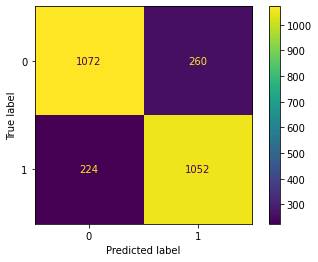

In [523]:
cm = confusion_matrix(y_test,pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [487]:
pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

total_spend           0.18
Spa                   0.11
CryoSleep             0.10
VRDeck                0.10
FoodCourt             0.09
RoomService           0.09
ShoppingMall          0.07
passenger_Id          0.06
cabin_deck_numeric    0.06
Age                   0.05
HomePlanet_numeric    0.05
cabin_side_numeric    0.02
Destination_numeric   0.02
family_member_no      0.01
VIP                   0.00
dtype: float64

# Submission

In [552]:
pred = best_rf.predict(submission_x)

In [553]:
submission = pd.DataFrame(zip(test_df.PassengerId,pred),columns=['PassengerId','Transported'])

In [554]:
submission.Transported=submission.Transported.astype(bool)

In [556]:
submission.to_csv("submission.csv",index = None)

In [557]:
!kaggle competitions submit -c spaceship-titanic -f submission.csv -m "Message"

100% 56.7k/56.7k [00:00<00:00, 102kB/s]
400 - Bad Request
